In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.time import Time
import glob
import aplpy
import sqlite3 
import gzip 
import io
import os
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import copy
import json
import avro
from avro.datafile import DataFileWriter, DataFileReader
from avro.io import DatumWriter, DatumReader

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50

# Set important constants

In [3]:
day_thres = 10 # days
now_jd = Time.now().jd
now_utc = Time.now()

## ***For today, let now_jd be 20 days ago

In [4]:
offset = 0 #days
now_jd -= offset

# Connect to database

In [45]:
conn = sqlite3.connect('/epyc/users/ykwang/Github/alert_stream_crossmatch/local/db/sqlite_pid2.db')
cutout_dir = '/epyc/users/ykwang/Github/alert_stream_crossmatch/local/cutouts/'

In [46]:
def show_stamps(ztf_object_id, im_dir=cutout_dir):
    #fig, axes = plt.subplots(1,3, figsize=(12,4))
    
    fig = plt.figure(figsize=(12,4))
    dirs = glob.glob(f"{im_dir}{ztf_object_id}*.fits")

    for i, cutout in enumerate(['Science','Template','Difference']):
        fits_dir = [x for x in dirs if cutout in x][0]
        ffig = plot_cutout(fits_dir, fig=fig, subplot = (1,3,i+1))
        ffig.set_title(ztf_object_id)
    fig.show()

# Quick look at objects seen

In [47]:
# cur = conn.cursor()
df = pd.read_sql_query("SELECT * FROM ZTF_objects", conn)
df
# cur.execute("SELECT * FROM ZTF_objects")
# df = pd.DataFrame(cur.fetchall())
df.columns = ['ztf_object_id', 'SIMBAD_otype', 'ra', 'dec', 'ROSAT_IAU_NAME',
       'SIMBAD_include', 'last_obs', 'seen_flag', 'interest_flag', 'notes']

In [48]:
# df[['ZTF21' in x for x in df['ztf_object_id']]].iloc[-50:]

In [49]:
df.loc[df['SIMBAD_include'] == 1]

,ztf_object_id,SIMBAD_otype,ra,dec,ROSAT_IAU_NAME,SIMBAD_include,last_obs,seen_flag,interest_flag,notes
2,ZTF18acctenq,EB*,45.502164,23.766712,2RXS J030200.8+234606,1.0,2.459271e+06,NaN,NaN,None
3233,ZTF18abjgxsf,EB*,338.947888,18.311449,2RXS J223549.6+181804,1.0,NaN,NaN,NaN,None
3247,ZTF18abcoxqh,*,336.034493,17.479413,2RXS J222408.0+172903,1.0,NaN,NaN,NaN,None
3261,ZTF19acvugzy,PM*,49.917256,23.909945,2RXS J031938.6+235453,1.0,2.459275e+06,NaN,NaN,None
3262,ZTF18acbvqqk,*,47.705896,19.753105,2RXS J031048.3+194518,1.0,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...
15503,ZTF17aaadzpn,V*,308.291928,48.540829,2RXS J203309.9+483229,1.0,2.459296e+06,0.0,1.0,None
15509,ZTF18acehvnt,*,300.421943,46.960240,2RXS J200142.4+465726,1.0,2.459296e+06,0.0,1.0,None
15514,ZTF17aaawczv,*,312.756563,45.372021,2RXS J205100.2+452151,1.0,2.459296e+06,0.0,1.0,None
15522,ZTF19abcluso,EB?,316.467275,20.546018,2RXS J210552.6+203234,1.0,2.459296e+06,0.0,1.0,None


# Read lightcurve data

In [50]:
cur = conn.cursor()
cur.execute("SELECT * FROM lightcurves")
dflc = pd.DataFrame(cur.fetchall())
dflc.columns = ['ztf_object_id', 'jd', 'fid', 'magpsf', 'sigmapsf', 'diffmaglim', 'isdiffpos', 'magnr', 'sigmagnr', 'field', 'rcid']
dflc[['jd', 'magpsf', 'sigmapsf', 'diffmaglim', 'magnr', 'sigmagnr', 'field', 'rcid']] = dflc[['jd', 'magpsf', 'sigmapsf', 'diffmaglim', 'magnr', 'sigmagnr', 'field', 'rcid']].astype(float)
dflc['fid'] = dflc['fid'].astype(int)

## ***For today, drop all rows taken after "now_jd"

In [51]:
dflc = dflc.loc[(now_jd - dflc['jd']) > 0]

<AxesSubplot:>

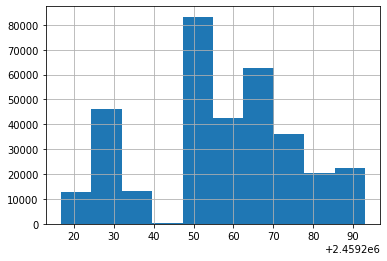

In [52]:
dflc['jd'].hist()

# Preprocess lightcurve data

### Impute missing magnr and sigmagnr

In [53]:
len(dflc['magnr'].dropna()) / len(dflc['magnr'])

0.6273777463835298

In [54]:
len(dflc['field'].dropna()) / len(dflc['field'])

0.2568922637705473

In [55]:
len(dflc['rcid'].dropna()) / len(dflc['rcid'])

0.2568922637705473

In [56]:
grp = dflc.groupby(['fid','field','rcid'])
impute_magnr = grp['magnr'].agg(lambda x: np.median(x[np.isfinite(x)]))
# print(impute_magnr)
impute_sigmagnr = grp['sigmagnr'].agg(lambda x: np.median(x[np.isfinite(x)]))
# print(impute_sigmagnr)

In [57]:
for idx, grpi in grp:
    w = np.isnan(grpi['magnr'])
    w2 = grpi[w].index
    dflc.loc[w2,'magnr'] = impute_magnr[idx]
    dflc.loc[w2,'sigmagnr'] = impute_sigmagnr[idx]

In [58]:
len(dflc['magnr'].dropna()) / len(dflc['magnr'])

0.6965343693435169

### Calculate DC magnitude

In [59]:
dflc['sign'] = 2* (dflc['isdiffpos'] == 't') - 1
dflc['sign']

0         1
1        -1
2         1
3        -1
4         1
         ..
351113   -1
351114   -1
351115   -1
351116   -1
351117   -1
Name: sign, Length: 339765, dtype: int64

In [60]:
u = 10**(-0.4*dflc['magnr']) + dflc['sign'] * 10**(-0.4*dflc['magpsf'])
dflc['dc_mag'] = -2.5 * np.log10(u)
dflc['dc_sigmag'] = np.sqrt(
    (10**(-0.4*dflc['magnr'])* dflc['sigmagnr']) **2. + 
    (10**(-0.4*dflc['magpsf']) * dflc['sigmapsf'])**2.) / u
dflc['dc_mag_ulim'] = -2.5 * np.log10(10**(-0.4*dflc['magnr']) + 10**(-0.4*dflc['diffmaglim']))
dflc['dc_mag_llim'] = -2.5 * np.log10(10**(-0.4*dflc['magnr']) - 10**(-0.4*dflc['diffmaglim']))

In [61]:
dflc.sign.dropna()

0         1
1        -1
2         1
3        -1
4         1
         ..
351113   -1
351114   -1
351115   -1
351116   -1
351117   -1
Name: sign, Length: 339765, dtype: int64

### Drop 0.5% of most uncertain obs

In [62]:
thres = dflc['dc_sigmag'].quantile(.995)
dflc = dflc.loc[~(dflc['dc_sigmag'] > thres)]

### Create new column with ulims subsituting nan dc_mag

In [63]:
dflc['combined_mag_ulim'] = [dflc.loc[ii, 'dc_mag_ulim'] if pd.isna(dflc.loc[ii, 'dc_mag']) else dflc.loc[ii, 'dc_mag'] for ii in dflc.index]

In [64]:
dflc['combined_mag_ulim'].dropna()

0         14.186017
2         13.044404
4         14.251781
6         14.136993
7         13.050532
            ...    
351113    18.058012
351114    15.808770
351115    18.085247
351116    18.070511
351117    18.042180
Name: combined_mag_ulim, Length: 235592, dtype: float64

In [65]:
# dflc['combined_mag_ulim'] = [dflc.loc[ii, 'diffmaglim'] if pd.isna(dflc.loc[ii, 'dc_mag']) else dflc.loc[ii, 'dc_mag'] for ii in dflc.index]

### Exclude objects with otypes we are not interested in

In [66]:
# interest = df.loc[df['SIMBAD_include'] == 1]
# mask = [x in interest['ztf_object_id'].values for x in dflc['ztf_object_id']]
# dflc_interest = dflc.loc[mask]


In [67]:
dflc_interest = dflc[dflc['ztf_object_id'].isin(df.loc[df['SIMBAD_include'] == 1, 'ztf_object_id'])]
dflc_interest

,ztf_object_id,jd,fid,magpsf,sigmapsf,diffmaglim,isdiffpos,magnr,sigmagnr,field,rcid,sign,dc_mag,dc_sigmag,dc_mag_ulim,dc_mag_llim,combined_mag_ulim
73,ZTF18acctenq,2.459244e+06,1,16.670269,0.090340,19.074606,t,13.162,0.020,NaN,NaN,1,13.119929,0.019544,13.157325,13.166695,13.119929
74,ZTF18acctenq,2.459217e+06,1,NaN,NaN,20.016701,None,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
75,ZTF18acctenq,2.459217e+06,2,NaN,NaN,19.739599,None,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
76,ZTF18acctenq,2.459219e+06,2,NaN,NaN,20.292500,None,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
77,ZTF18acctenq,2.459219e+06,1,NaN,NaN,20.721201,None,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351035,ZTF18abjuixy,2.459293e+06,2,18.150499,0.108026,19.885300,f,16.865,0.023,689.0,53.0,-1,17.261688,0.058038,16.799763,16.934408,17.261688
351036,ZTF18abjuixy,2.459293e+06,2,18.189100,0.114755,19.906401,f,16.865,0.023,689.0,53.0,-1,17.245090,0.058132,16.800982,16.933030,17.245090
351037,ZTF18abjuixy,2.459293e+06,2,18.273600,0.097452,19.951799,f,16.865,0.023,689.0,53.0,-1,17.211537,0.048416,16.803531,16.930158,17.211537
351038,ZTF18abjuixy,2.459293e+06,2,18.419800,0.125398,19.965900,f,16.865,0.023,689.0,53.0,-1,17.161289,0.049609,16.804303,16.929292,17.161289


In [68]:
dflc_interest[['dc_mag', 'dc_mag_ulim']].dropna(how='all')

,dc_mag,dc_mag_ulim
73,13.119929,13.157325
82,13.217732,13.160309
87,13.328526,13.161006
89,13.335475,13.160890
853,13.180293,13.292045
...,...,...
351035,17.261688,16.799763
351036,17.245090,16.800982
351037,17.211537,16.803531
351038,17.161289,16.804303


In [69]:
dflc_interest[['dc_mag', 'dc_mag_ulim', 'combined_mag_ulim']]

,dc_mag,dc_mag_ulim,combined_mag_ulim
73,13.119929,13.157325,13.119929
74,NaN,NaN,NaN
75,NaN,NaN,NaN
76,NaN,NaN,NaN
77,NaN,NaN,NaN
...,...,...,...
351035,17.261688,16.799763,17.261688
351036,17.245090,16.800982,17.245090
351037,17.211537,16.803531,17.211537
351038,17.161289,16.804303,17.161289


### Set df index to id and filter, then sort by time

In [70]:
# len(dflc_interest['ztf_object_id'].unique())

dflc_interest['utc'] = pd.to_datetime(dflc_interest['jd'], unit='D', origin='julian')
dflc_interest.set_index(['ztf_object_id', 'fid'], inplace=True)
dflc_interest = dflc_interest.sort_values('utc').sort_index()

### Get list of ids seen in the past X days

In [71]:
last_seen = dflc_interest.groupby('ztf_object_id')['jd'].max()
new_sources = last_seen.loc[(now_jd - last_seen) < day_thres].index

In [72]:
print(f"Number of new sources: {len(new_sources)}")

Number of new sources: 468


### Calculate exponential weighted moving averages
using timescales of 2, 8, and 28 days

In [73]:
dflc_interest['ema2'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["dc_mag"].ewm(halflife='2 days', times=x['utc']).mean()).values
dflc_interest['ema8'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["dc_mag"].ewm(halflife='8 days', times=x['utc']).mean()).values
dflc_interest['ema28'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["dc_mag"].ewm(halflife='28 days', times=x['utc']).mean()).values

In [74]:
dflc_interest['combined_ema2'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ulim"].ewm(halflife='2 days', times=x['utc']).mean()).values
dflc_interest['combined_ema8'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ulim"].ewm(halflife='8 days', times=x['utc']).mean()).values
dflc_interest['combined_ema28'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ulim"].ewm(halflife='28 days', times=x['utc']).mean()).values

In [75]:
# %time
# dflc_interest['ema4'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["dc_mag"].ewm(halflife='4 days', times=x['utc']).mean()).values


### Calculate our metric for outbursting

- Take difference between 8day halflife EWMA and dc_magnitude
- Take the 4 day halflife EWMA of these differences

In [76]:
dflc_interest['mag_ewm_diff8'] = dflc_interest['dc_mag'] - dflc_interest['ema8']
dflc_interest['mag_ewm_diff8_rolling4'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["mag_ewm_diff8"].ewm(halflife='4 days', times=x['utc']).mean()).values

In [77]:
dflc_interest['combined_mag_ewm_diff8'] = dflc_interest['combined_mag_ulim'] - dflc_interest['combined_ema8']
dflc_interest['combined_mag_ewm_diff8_rolling4'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ewm_diff8"].ewm(halflife='4 days', times=x['utc']).mean()).values

### Get data for new sources only and time range we care about 

In [78]:
dflc_interest_new = dflc_interest.loc[new_sources]

In [79]:
ndays_thres = 30
dflc_interest_new = dflc_interest_new.loc[(now_jd - dflc_interest_new['jd']) < ndays_thres]

### Sort our data by max abs magnitude of our metric in the past X day

In [80]:
recent = dflc_interest_new.loc[(now_jd - dflc_interest_new['jd']) < day_thres]
order_by_max = recent.groupby("ztf_object_id")['mag_ewm_diff8_rolling4'].apply(lambda x: x.abs().max()).sort_values(ascending=False).index

# Visualize results

In [41]:
dflc_interest_new['utc'].max()

Timestamp('2021-03-19 12:55:15.997440')

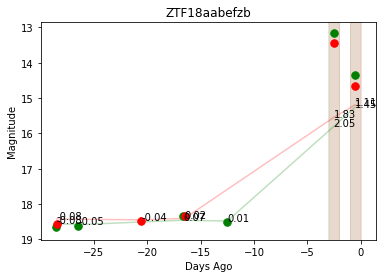

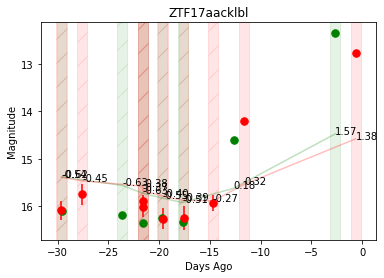

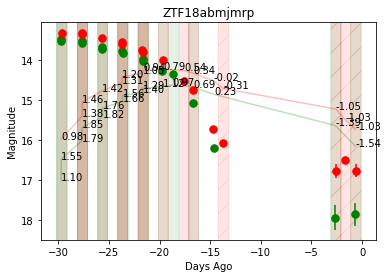

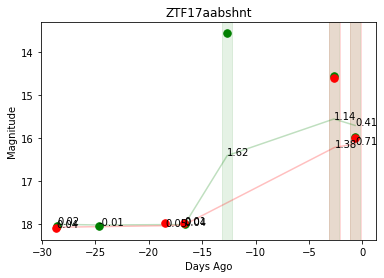

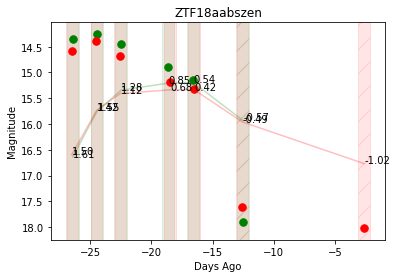

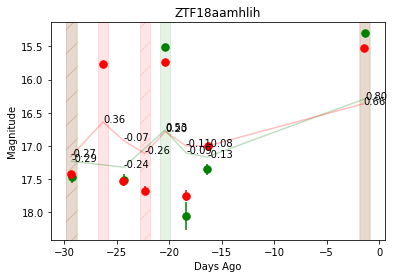

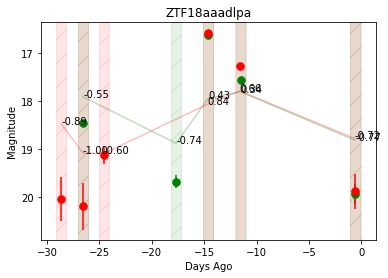

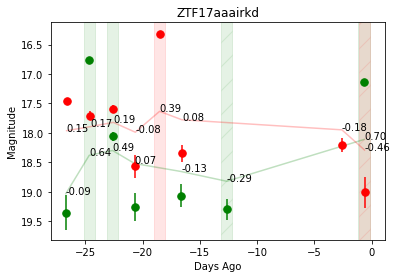

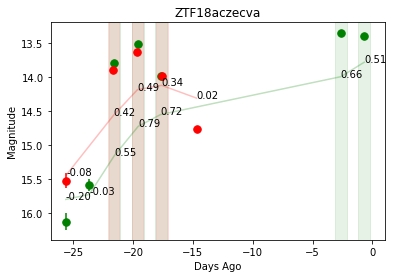

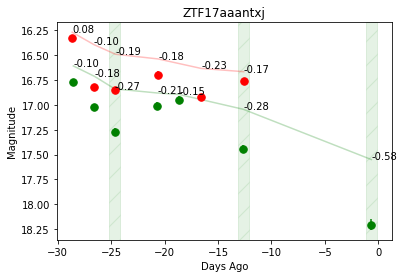

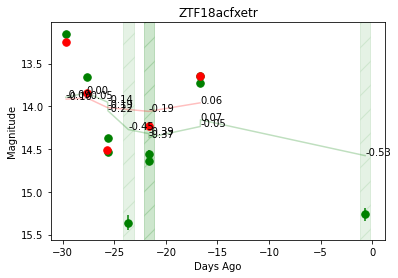

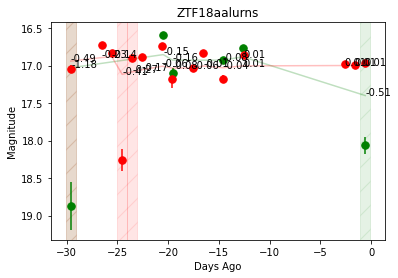

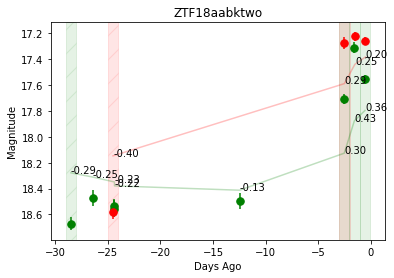

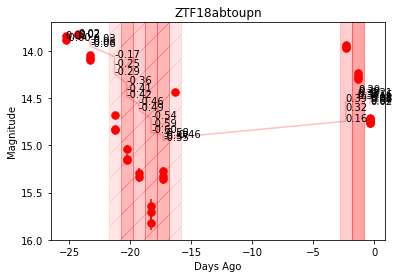

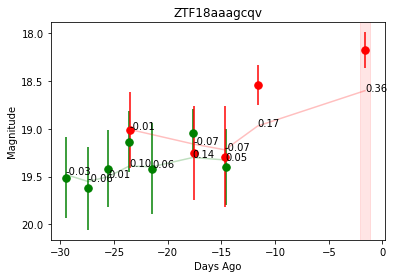

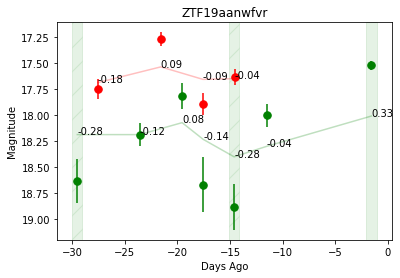

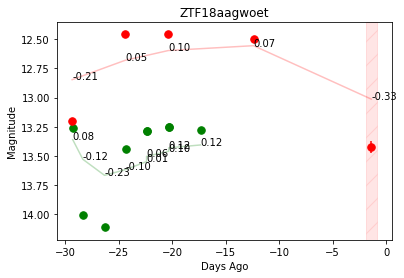

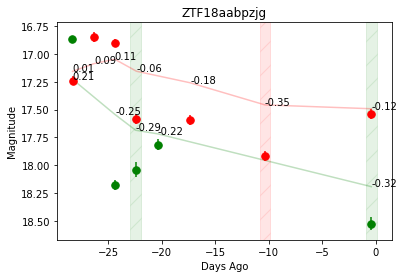

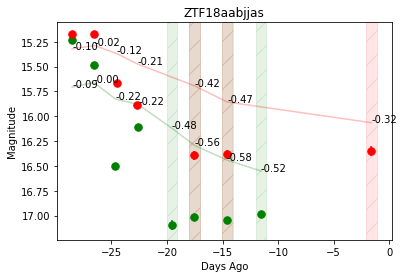

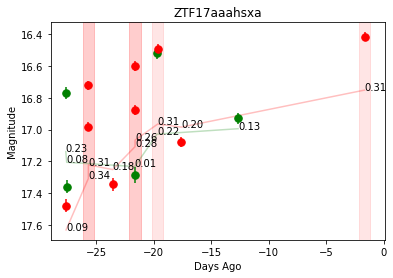

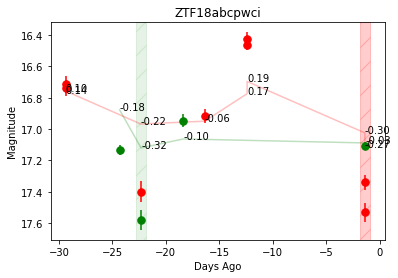

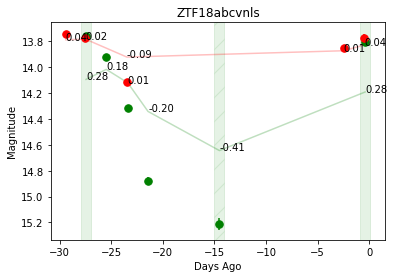

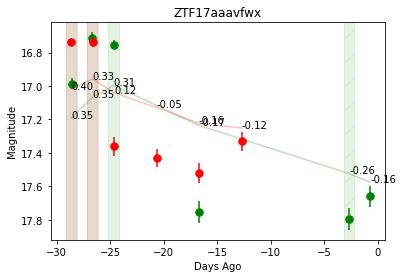

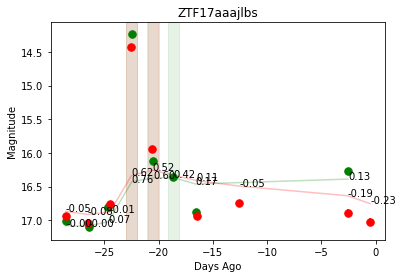

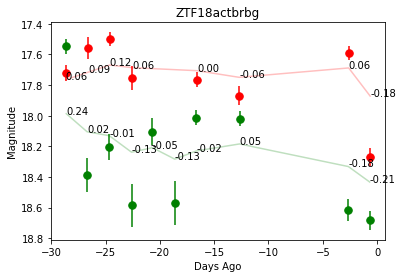

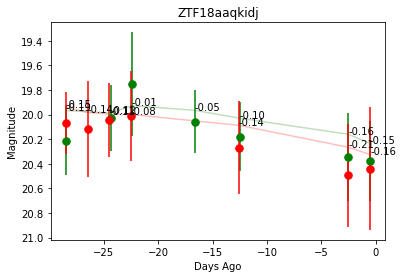

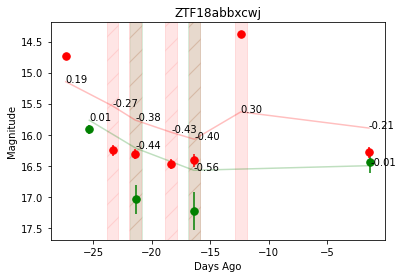

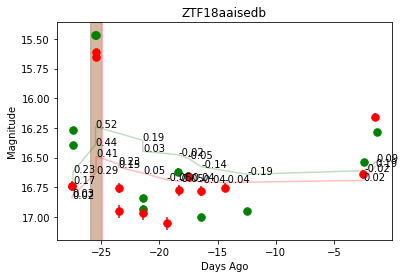

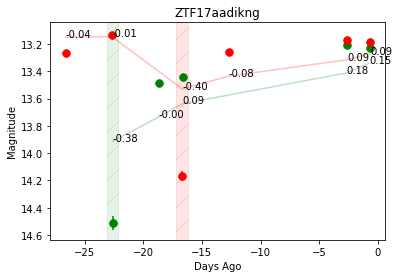

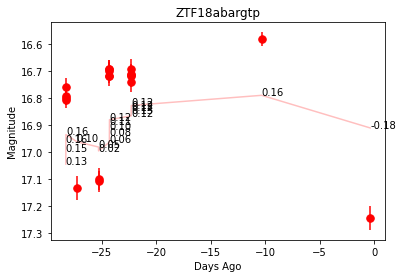

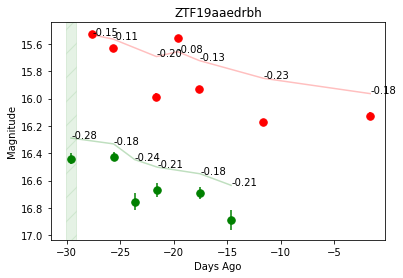

In [44]:
for x in order_by_max[:50]:
    sub = dflc_interest_new.loc[x].dropna(subset=['dc_mag'])
    if len(sub) > 10:
        plot_dc_lightcurve(sub.reset_index(), x, ema='ema8', ema_diff='mag_ewm_diff8_rolling4', offset=offset)
        # show_stamps(x)
    # mark_seen(conn, x)

### Do the same, but now include dc_mag_ulim into the rolling calculations

In [185]:
combined_order_by_max = recent.groupby("ztf_object_id")['combined_mag_ewm_diff8_rolling4'].apply(lambda x: x.abs().max()).sort_values(ascending=False).index

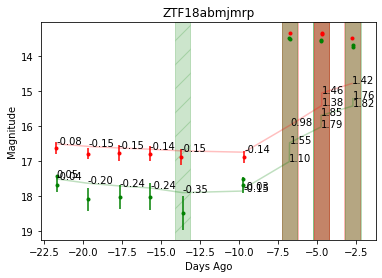

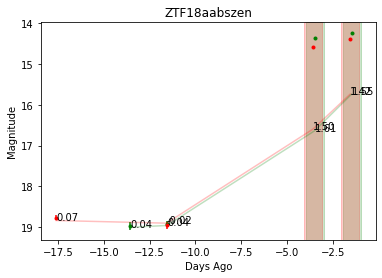

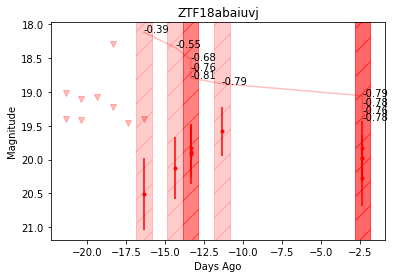

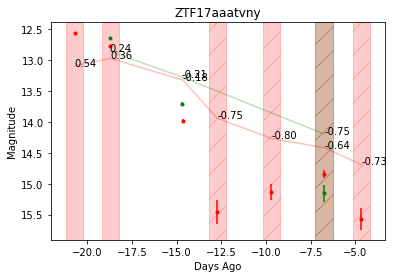

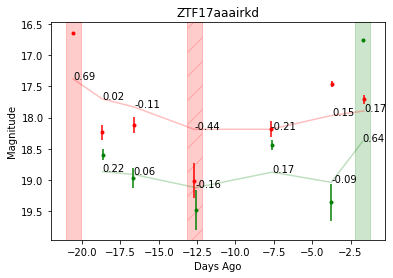

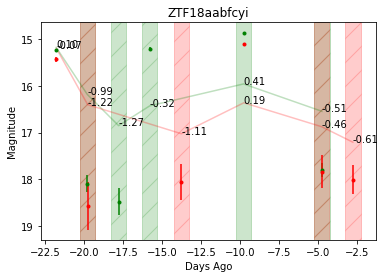

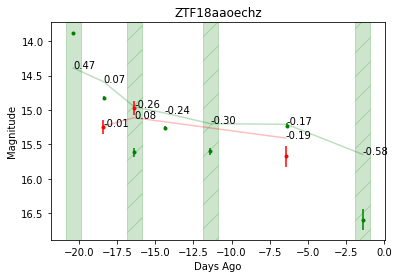

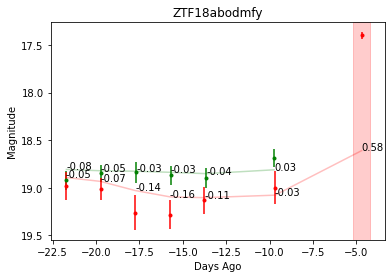

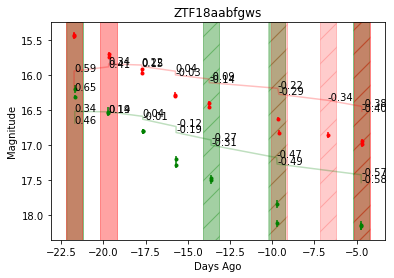

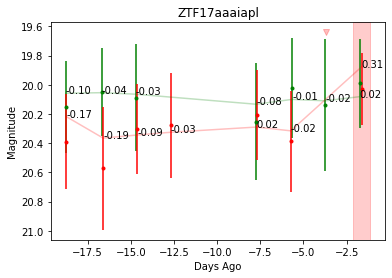

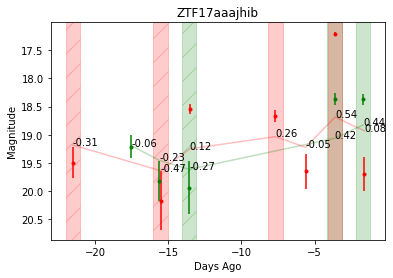

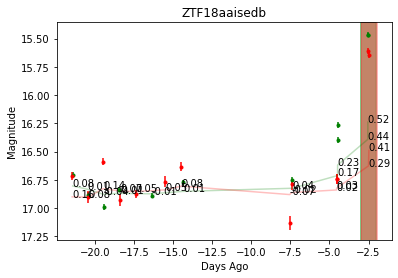

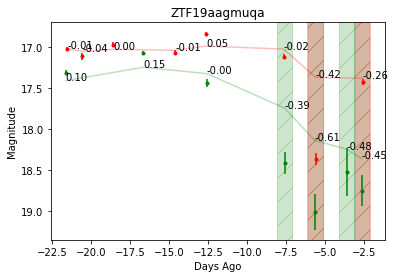

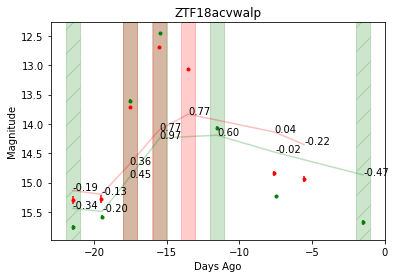

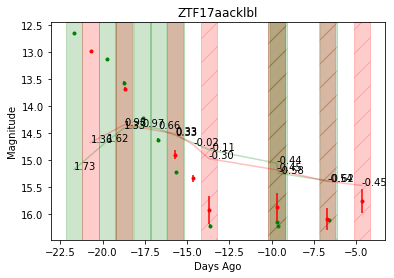

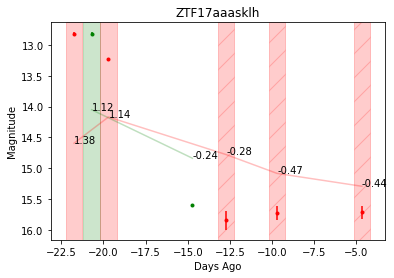

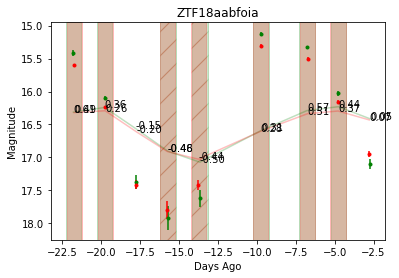

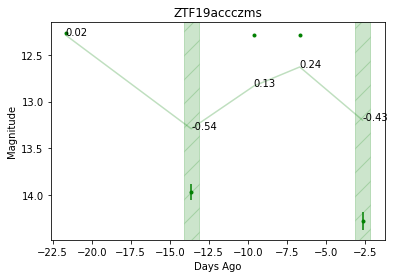

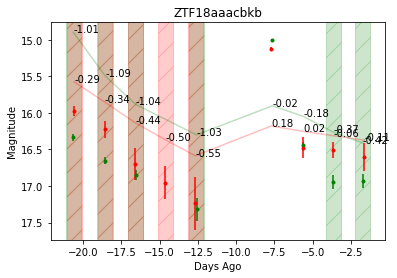

In [186]:
for x in combined_order_by_max[:20]:
    sub = dflc_interest_new.loc[x].dropna(subset=['diffmaglim'])
    if len(sub) > 3:
        plot_dc_lightcurve_lim(sub.reset_index(), x, ema='combined_ema8', ema_diff='combined_mag_ewm_diff8_rolling4', offset=offset)
    mark_seen(conn, x):
    # show_stamps(x)

In [35]:
(dflc['dc_mag_llim'] - dflc['dc_mag_ulim']).quantile([.5, .9, .99])

0.50    0.197219
0.90    0.753553
0.99    2.143987
dtype: float64

In [38]:
dflc.head()

,ztf_object_id,jd,fid,magpsf,sigmapsf,diffmaglim,isdiffpos,magnr,sigmagnr,sign,dc_mag,dc_sigmag,dc_mag_ulim,dc_mag_llim
0,ZTF19abceihx,2.459219e+06,1,19.221775,0.175954,19.369980,f,17.524,0.014,-1,17.779051,0.049843,17.341864,17.742974
1,ZTF19abceihx,2.459190e+06,2,19.011000,0.137446,19.469000,f,17.299,0.018,-1,17.550315,0.042382,17.161014,17.457111
2,ZTF19abceihx,2.459190e+06,2,18.864500,0.107180,19.620899,f,17.243,0.020,-1,17.519178,0.040361,17.127833,17.371849
3,ZTF19abceihx,2.459193e+06,2,18.951799,0.252563,18.841499,f,17.299,0.018,-1,17.566278,0.074160,17.064093,17.599177
4,ZTF19abceihx,2.459193e+06,2,18.754900,0.192248,18.947001,f,17.243,0.020,-1,17.553106,0.068901,17.037688,17.496408


In [ ]:
dflc_interest['ema2'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["dc_mag"].ewm(halflife='2 days', times=x['utc']).mean()).values
dflc_interest['ema8'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["dc_mag"].ewm(halflife='8 days', times=x['utc']).mean()).values
dflc_interest['ema28'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["dc_mag"].ewm(halflife='28 days', times=x['utc']).mean()).values

In [179]:
dflc_interest_new.loc['ZTF18aabeymw']

,jd,magpsf,sigmapsf,diffmaglim,isdiffpos,magnr,sigmagnr,sign,dc_mag,dc_sigmag,dc_mag_ulim,dc_mag_llim,utc,ema2,ema8,ema28,mag_ewm_diff8,mag_ewm_diff8_rolling4
fid,,,,,,,,,,,,,,,,,,
1,2.459207e+06,15.423200,0.189400,16.164600,t,19.076,0.027,1,15.386285,0.183071,16.092704,NaN,2020-12-23 07:50:55.003200,15.309685,15.228198,15.204187,0.158087,0.117269
1,2.459208e+06,NaN,NaN,16.731800,None,NaN,NaN,-1,NaN,NaN,NaN,NaN,2020-12-24 04:23:04.001280,15.309685,15.228198,15.204187,NaN,0.117269
1,2.459211e+06,16.685801,0.047453,19.220301,t,19.076,0.027,1,16.571865,0.042810,18.393180,21.338493,2020-12-27 05:17:40.004160,16.166324,15.648005,15.518220,0.923860,0.472788
1,2.459212e+06,NaN,NaN,19.123100,None,NaN,NaN,-1,NaN,NaN,NaN,NaN,2020-12-28 05:18:10.995840,16.166324,15.648005,15.518220,NaN,0.472788
1,2.459217e+06,NaN,NaN,19.430599,None,NaN,NaN,-1,NaN,NaN,NaN,NaN,2021-01-02 04:12:20.001600,16.166324,15.648005,15.518220,NaN,0.472788
1,2.459217e+06,19.267799,0.228276,19.372499,t,19.076,0.027,1,18.415095,0.105114,18.461585,20.630130,2021-01-02 07:59:47.002560,18.076711,16.607247,16.128908,1.807848,1.220037
1,2.459219e+06,19.778028,0.118267,20.633381,t,19.211,0.021,1,18.705336,0.045964,18.951659,19.552401,2021-01-04 05:20:22.004160,18.466777,17.215551,16.595072,1.489785,1.337944
1,2.459221e+06,19.791643,0.122570,20.722210,t,19.211,0.021,1,18.710385,0.047174,18.969935,19.521335,2021-01-06 04:49:11.003520,18.601229,17.598276,16.932835,1.112109,1.251872
1,2.459225e+06,19.251272,0.175153,20.141983,t,19.076,0.027,1,18.407528,0.081834,18.730533,19.585664,2021-01-10 04:40:46.004160,18.467999,17.813320,17.153826,0.594208,0.967567


In [43]:
def plot_lightcurve(dflc, obj_id='', days_ago=True):
    
    filter_color = {1:'green', 2:'red', 3:'pink'}
    if days_ago:
        now = Time.now().jd
        t = dflc.jd - now
        xlabel = 'Days Ago'
    else:
        t = dflc.jd
        xlabel = 'Time (JD)'
    
    plt.figure()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
        if np.sum(w):
            plt.errorbar(t[w],dflc.loc[w,'magpsf'], dflc.loc[w,'sigmapsf'],fmt='.',color=color)
        wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
        if np.sum(wnodet):
            plt.scatter(t[wnodet],dflc.loc[wnodet,'diffmaglim'], marker='v',color=color,alpha=0.25)
    
    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Magnitude')
    if obj_id:
        plt.title(obj_id)

        
def plot_dc_lightcurve(dflc, obj_id='', days_ago=True, ema='', ema_diff='', offset=0, metric_thres=.25):
    
    filter_color = {1:'green', 2:'red', 3:'pink'}
    if days_ago:
        now = Time.now().jd
        t = dflc.jd - now + offset
        xlabel = 'Days Ago'
    else:
        t = dflc.jd
        xlabel = 'Time (JD)'
    
    plt.figure()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.fid == fid) & ~dflc.dc_mag.isnull()
        if np.sum(w):
            plt.errorbar(t[w],dflc.loc[w,'dc_mag'], dflc.loc[w,'dc_sigmag'],fmt='.', markersize=15, color=color)
            if ema:
                plt.plot(t[w],dflc.loc[w,ema],color=color, alpha=.25, label=ema)
            if ema_diff:
                for ii in range(len(w)):
                    if w[ii]:
                        plt.annotate('{:.2f}'.format(-dflc.loc[ii,ema_diff]), (t[ii], dflc.loc[ii, ema]))
                        if dflc.loc[ii,ema_diff] > metric_thres:
                            plt.axvspan(t[ii]-.49, t[ii]+.49, color=color, alpha=0.1, hatch='/')
                        if dflc.loc[ii,ema_diff] < -metric_thres:
                            plt.axvspan(t[ii]-.49, t[ii]+.49, color=color, alpha=0.1)

#         if np.sum(wnodet):
#             plt.scatter(t[wnodet],dflc.loc[wnodet,'dc_mag_ulim'], marker='v',color=color,alpha=0.25)

    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Magnitude')
    if obj_id:
        plt.title(obj_id)
    plt.show()

        
def plot_dc_lightcurve_lim(dflc, obj_id='', days_ago=True, ema='', ema_diff='', offset=0, metric_thres=.25):
    
    filter_color = {1:'green', 2:'red', 3:'pink'}
    if days_ago:
        now = Time.now().jd
        t = dflc.jd - now + offset
        xlabel = 'Days Ago'
    else:
        t = dflc.jd
        xlabel = 'Time (JD)'
    
    plt.figure()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.fid == fid) & ~dflc.dc_mag.isnull()
        if np.sum(w):
            plt.errorbar(t[w],dflc.loc[w,'dc_mag'], dflc.loc[w,'dc_sigmag'],fmt='.',color=color)
            if ema:
                plt.plot(t[w],dflc.loc[w,ema],color=color, alpha=.25, label=ema)
            if ema_diff:
                for ii in range(len(w)):
                    if w[ii]:
                        plt.annotate('{:.2f}'.format(-dflc.loc[ii,ema_diff]), (t[ii], dflc.loc[ii, ema]))
                        if dflc.loc[ii,ema_diff] > metric_thres:
                            plt.axvspan(t[ii]-.49, t[ii]+.49, color=color, alpha=0.2, hatch='/')
                        if dflc.loc[ii,ema_diff] < -metric_thres:
                            plt.axvspan(t[ii]-.49, t[ii]+.49, color=color, alpha=0.2)
                        
        wnodet = (dflc.fid == fid) & dflc.dc_mag.isnull()
        if np.sum(wnodet):
            plt.scatter(t[wnodet],dflc.loc[wnodet,'diffmaglim'], marker='v',color=color,alpha=0.25)

    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Magnitude')
    if obj_id:
        plt.title(obj_id)
    plt.show()
        
        
def plot_cutout(fits_dir, fig=None, subplot=None, **kwargs):
    with fits.open(fits_dir) as hdul:
        if fig is None:
            fig = plt.figure(figsize=(4,4))
        if subplot is None:
            subplot = (1,1,1)
        ffig = aplpy.FITSFigure(hdul[0],figure=fig, subplot=subplot, **kwargs)
        ffig.show_grayscale(stretch='arcsinh')
    return ffig

def show_stamps(ztf_object_id, im_dir=cutout_dir):
    #fig, axes = plt.subplots(1,3, figsize=(12,4))
    
    fig = plt.figure(figsize=(12,4))
    dirs = glob.glob(f"{im_dir}{ztf_object_id}*.fits")

    for i, cutout in enumerate(['Science','Template','Difference']):
        fits_dir = [x for x in dirs if cutout in x][0]
        ffig = plot_cutout(fits_dir, fig=fig, subplot = (1,3,i+1))
        ffig.set_title(ztf_object_id)
    fig.show()
    
def show_all(packet):
    fig = plt.figure(figsize=(16,4))
    dflc = make_dataframe(packet)
    plot_lightcurve(dflc,ax = plt.subplot(1,4,1))
    for i, cutout in enumerate(['Science','Template','Difference']):
        stamp = packet['cutout{}'.format(cutout)]['stampData']
        ffig = plot_cutout(stamp, fig=fig, subplot = (1,4,i+2))
        ffig.set_title(cutout)
        
def get_ewm_mag(dflc_obj, tau):
    return dflc_obj['dc_mag'].ewm(halflife=tau, times = dflc_obj['utc']).mean()

def update_value(conn, val_dict, condition, table='ZTF_objects'):
    """Update the value of col with val, for the given conditions
    Ex. val_dict = {'SIMBAD_otype': '\"Sy1\"'}, condition = 'ZTF_object_id = \"ZTF19abkfpqk\"' """
    cur = conn.cursor()
    try:
        cur.execute(f"UPDATE {table} SET " + ", ".join([f"{col} = {val_dict[col]}" for col in val_dict.keys()]) +
                    f" WHERE {condition}")
    except Error as e:
        raise Exception(f"Error updating values {e}")
    conn.commit()

def mark_seen(conn, ztf_object_id):
    data_to_update = {"seen_flag": 1}
    update_value(conn, data_to_update, f'ZTF_object_id = "{ztf_object_id}"')

In [19]:
cvs = [
    "ZTF18aaroihf",
"ZTF17aacqkto",
"ZTF18aabeymw",
"ZTF17aaaadkj",
"ZTF19aaaonhi",
"ZTF18aagrtri",
"ZTF17aabxrbe",
"ZTF18abscxct",
]

In [ ]:
# example updating
data_to_update = {"SIMBAD_otype": f'"{otype}"', "ra": packet["candidate"]["ra"],
                  "dec": packet["candidate"]["dec"], "SIMBAD_include": interest}
# update_value(conn, data_to_update, f'ZTF_object_id = "{ztf_object_id}"')

### Add columns to existing dbs

In [81]:
def add_column(conn, table, col_name, col_type):
    cur = conn.cursor()
    cur.execute(f"ALTER TABLE {table} ADD COLUMN {col_name} {col_type};")
    return pd.read_sql_query(f"SELECT * FROM {table}", conn).dtypes


In [133]:
conn_debug = sqlite3.connect('/epyc/users/ykwang/Github/alert_stream_crossmatch/local/db/sqlitedebug.db')


In [134]:
add_column(conn_debug, 'ZTF_objects', 'last_obs', 'float')
add_column(conn_debug, 'ZTF_objects', 'seen_flag', 'int')
add_column(conn_debug, 'ZTF_objects', 'interest_flag', 'int')
add_column(conn_debug, 'ZTF_objects', 'notes', 'text')

ZTF_object_id      object
SIMBAD_otype       object
ra                float64
dec               float64
ROSAT_IAU_NAME     object
SIMBAD_include    float64
last_obs           object
seen_flag          object
interest_flag      object
notes              object
dtype: object

In [90]:
pd.read_sql_query("SELECT * FROM lightcurves", conn).dtypes

ZTF_object_id     object
jd                object
fid               object
magpsf           float64
sigmapsf         float64
diffmaglim       float64
isdiffpos         object
magnr            float64
sigmagnr         float64
dtype: object

In [182]:
conn_debug = sqlite3.connect('/epyc/users/ykwang/Github/alert_stream_crossmatch/local/db/sqlitedebug.db')

pd.read_sql_query("SELECT * FROM ZTF_objects", conn_debug).dropna(subset=['ra'])

,ZTF_object_id,SIMBAD_otype,ra,dec,ROSAT_IAU_NAME,SIMBAD_include,last_obs,seen_flag,interest_flag,notes
30,ZTF18aabezub,None,40.207699,49.865258,2RXS J024048.8+495203,0.0,2.459270e+06,0.0,0.0,None
31,ZTF18acmysaq,BLL,53.486514,65.615648,2RXS J033357.0+653705,0.0,2.459270e+06,0.0,0.0,None
32,ZTF20aaffcza,None,57.535898,76.662918,2RXS J035011.9+764002,0.0,2.459270e+06,0.0,0.0,None
33,ZTF18absqkfg,G,43.684938,47.442902,2RXS J025444.0+472639,0.0,2.459270e+06,0.0,0.0,None
34,ZTF19abjolmq,None,64.610641,73.275639,2RXS J041824.0+731635,0.0,2.459270e+06,0.0,0.0,None
...,...,...,...,...,...,...,...,...,...,...
336,ZTF18acbzkta,None,63.756536,32.335179,2RXS J041501.6+322002,0.0,2.459270e+06,0.0,0.0,None
337,ZTF18abydmyu,DN*,86.951510,28.586512,2RXS J054748.5+283511,1.0,2.459270e+06,0.0,1.0,None
338,ZTF18achucnm,None,63.549904,36.601002,2RXS J041413.5+363554,0.0,2.459270e+06,0.0,0.0,None
339,ZTF18acdyfgs,QSO,38.043686,32.663463,2RXS J023209.8+323932,0.0,2.459270e+06,0.0,0.0,None


In [84]:
cnx = sqlite3.connect('/epyc/users/ykwang/Github/alert_stream_crossmatch/local/db/sqlitesimple.db')
add_column(cnx, 'lightcurves', 'field', 'int')
add_column(cnx, 'lightcurves', 'rcid', 'int')
pd.read_sql_query("SELECT * FROM lightcurves", cnx)

,ZTF_object_id,jd,fid,magpsf,sigmapsf,diffmaglim,isdiffpos,magnr,sigmagnr,field,rcid
0,ZTF19abceihx,2459218.6020023,1,19.221775,0.175954,19.369980,f,17.524000,0.014,None,None
1,ZTF19abceihx,2459189.6685648,2,19.011000,0.137446,19.469000,f,17.299000,0.018,None,None
2,ZTF19abceihx,2459189.6930556,2,18.864500,0.107180,19.620899,f,17.243000,0.020,None,None
3,ZTF19abceihx,2459192.6256366,2,18.951799,0.252563,18.841499,f,17.299000,0.018,None,None
4,ZTF19abceihx,2459192.627037,2,18.754900,0.192248,18.947001,f,17.243000,0.020,None,None
...,...,...,...,...,...,...,...,...,...,...,...
374540,ZTF18abtoupn,2459274.0565162,2,15.225590,0.020630,18.288145,f,14.506000,0.020,None,None
374541,ZTF18aborthl,2459274.0565162,2,17.907963,0.153364,18.162607,f,16.231001,0.026,None,None
374542,ZTF18abtovjo,2459274.0545486,2,17.512791,0.111764,18.462793,t,16.457001,0.015,None,None
374543,ZTF18absuniq,2459274.0574537,2,17.610895,0.168301,18.063719,t,15.917999,0.016,None,None


In [89]:
cnx = sqlite3.connect('/epyc/users/ykwang/Github/alert_stream_crossmatch/local/db/sqlitedebug.db')
pd.read_sql_query("SELECT * FROM lightcurves", cnx)

,ZTF_object_id,jd,fid,magpsf,sigmapsf,diffmaglim,isdiffpos,magnr,sigmagnr,field,rcid
0,ZTF18aabezub,2459269.6372801,2,18.705532,0.082297,20.220669,f,18.289000,0.020,NaN,NaN
1,ZTF18aabezub,2459248.6617593,2,18.890499,0.094581,20.413300,f,18.289000,0.020,NaN,NaN
2,ZTF18aabezub,2459248.7015972,1,18.811001,0.095207,20.477900,f,18.368999,0.034,NaN,NaN
3,ZTF18aabezub,2459250.6761574,2,18.921400,0.107312,19.907301,f,18.289000,0.020,NaN,NaN
4,ZTF18aabezub,2459250.7026157,1,18.815800,0.110672,20.051100,f,18.368999,0.034,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
40024,ZTF21aanswqf,2459274.0574537,2,NaN,NaN,17.979700,None,NaN,NaN,542.0,20.0
40025,ZTF21aanswqf,2459275.0508449,2,NaN,NaN,18.607500,None,NaN,NaN,542.0,20.0
40026,ZTF21aanswqf,2459275.0532755,2,NaN,NaN,18.440001,None,NaN,NaN,542.0,20.0
40027,ZTF18abtovjo,2459275.0552431,2,17.455315,0.076400,18.567413,t,16.457001,0.015,593.0,31.0
